# HDBSCAN

- sources:
    - clustering in higher dimensions https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6
    - how hdbscan works: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
    - euclidian distance no good in high dimensional space: https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions


# Imports

In [1]:
# installs
import sys
!conda install --yes --prefix {sys.prefix} nltk bs4 gensim
!conda install --yes --prefix {sys.prefix} -c conda-forge hdbscan
import nltk
nltk.download('stopwords')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - bs4
    - gensim
    - nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boto-2.49.0                |             py_0         838 KB  conda-forge
    boto3-1.12.43              |     pyh9f0ad1d_0          69 KB  conda-forge
    botocore-1.15.43           |     pyh9f0ad1d_0         3.8 MB  conda-forge
    bs4-4.8.2                  |                1           4 KB  conda-forge
    bz2file-0.98               |      

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import re
import string
import nltk

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.sklearn_api import D2VTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples

from sklearn.cluster import DBSCAN

from hdbscan import HDBSCAN

# Reading and preprocessing

In [3]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

In [4]:
featureSet = pd.DataFrame()
featureSet['TARGET'] = complaints['Product'].copy()
featureSet['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].copy()
featureSet.shape

(485701, 2)

In [5]:
data = featureSet.sample(10000,random_state=7844569)

pd.set_option('max_colwidth', None)
data[['Product','Consumer complaint narrative']].head()

In [6]:
stopWords = stopWords = set(stopwords.words('english'))

def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [7]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)

# Feature Extraction: doc2vec + t-sne

In [8]:
docsAsListOfStrings = [doc for i, doc in enumerate(row.split() for row in data['Consumer complaint narrative'])]
model = D2VTransformer(size=100, window=5, min_count=3, workers=8)
d2v = model.fit_transform(docsAsListOfStrings)

In [9]:
tsne = TSNE(n_components = 2)
d2v_tsne = tsne.fit_transform(d2v)

In [10]:
pca = PCA(n_components = 5)
d2v_pca = pca.fit_transform(d2v)

# Train/Test split

In [11]:
y = data['TARGET']
x = d2v_tsne

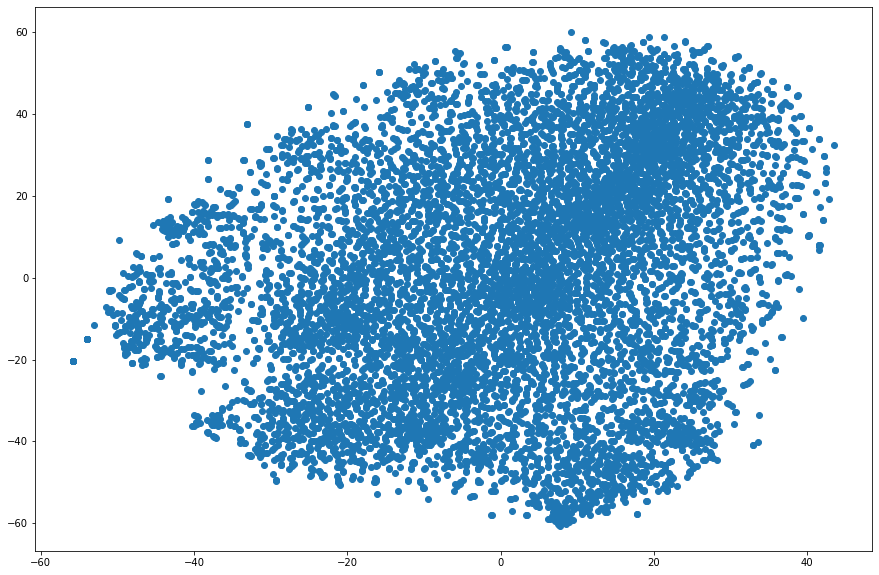

In [12]:
plt.figure(figsize=(15,10))
plt.scatter(x[:,0], x[:,1])

# HDBSCAN

In [13]:
clusterer = HDBSCAN(min_cluster_size=5, metric='l2')
cluster_labels = clusterer.fit_predict(x)
clusterer.labels_


array([ 53,  -1,  -1, ..., 452, 365, 234])

In [14]:
unique, counts = np.unique(clusterer.labels_, return_counts=True)
for i in range(0, len(unique)):
#     print(str(unique[i]) + "\t" + str(counts[i]))



SyntaxError: unexpected EOF while parsing (<ipython-input-14-e265b6502ac2>, line 4)

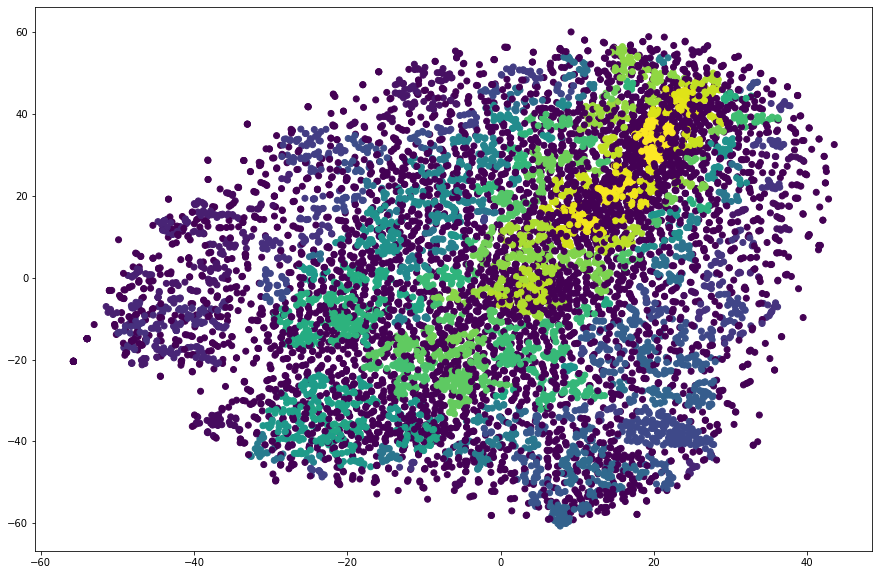

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(x[:,0], x[:,1], c=cluster_labels)

In [17]:
# https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6
# determine score of cluster by probabilities of points
# score is fraction of samples that have a low change of being assigned to a cluster
low = 2
high = 30
scores = []
for i in range(low, high):
    hdbscan = HDBSCAN(min_cluster_size=i)
    hdbscan.fit(x)
    count = list(filter(lambda prob: prob < 0.05, hdbscan.probabilities_))
    scores.append(len(count)/x.shape[0])


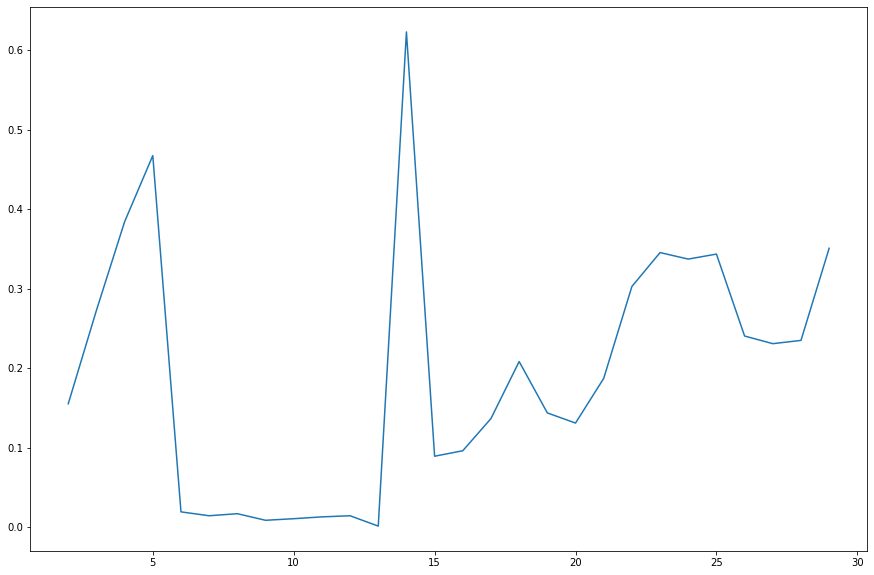

In [18]:
plt.figure(figsize=(15,10))
plt.plot(range(low,high), scores)

# Plotting silhouette avgs

In [19]:
def makesilhouetteplot(X,no_clusters):
    '''
    This function creates a silhouette plot after applying k-means clustering to the numpy array X, using k=no_clusters
    
    Args:
    * X: Numpy array of tuples: [[item1_x, item1_y], [item2_x, item2_y] ,... ]
    * no_clusters: the number of clusters to use in the k-means algorithm  
    '''
    km = KMeans(n_clusters=no_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04)
    y_km = km.fit_predict(X)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)
      plt.barh(range(y_ax_lower, y_ax_upper),
           c_silhouette_vals,
           height=1.0,
           edgecolor='none',
           color=color)
      yticks.append((y_ax_lower + y_ax_upper) / 2.)
      y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

In [20]:
def silhouetteavgs(X,no_clusters):
    km = KMeans(n_clusters=no_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04)
    y_km = km.fit_predict(X)
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    silhouette_avg = np.mean(silhouette_vals)
    return silhouette_avg

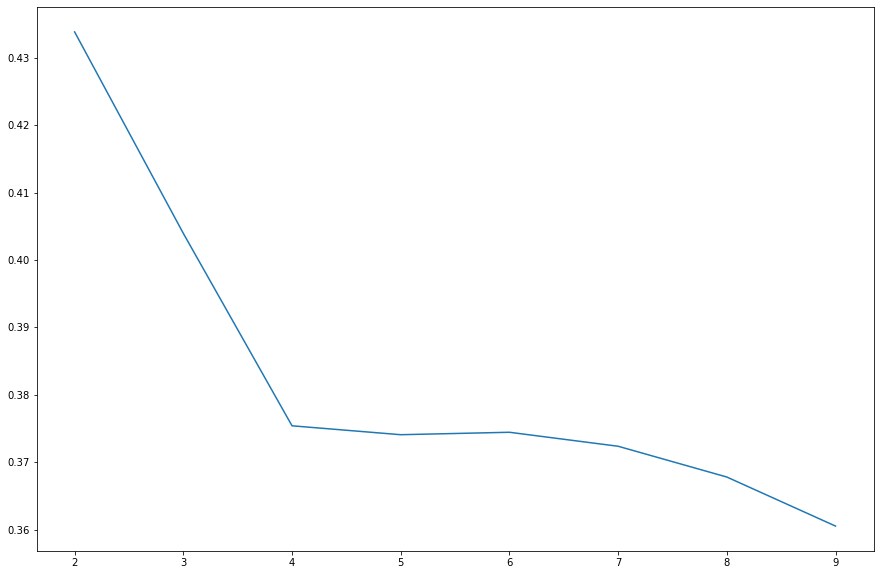

In [21]:
avgs = []
for i in range(2,10):
    avgs.append(silhouetteavgs(x, i))
    
plt.figure(figsize=(15,10))
plt.plot(range(2,10), avgs)


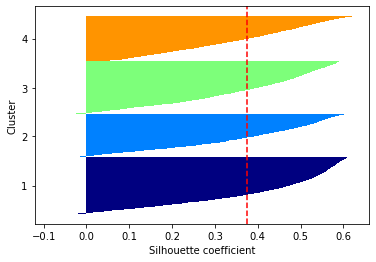

In [23]:
makesilhouetteplot(x, 4)

In [24]:
x[:,1].shape

(10000,)

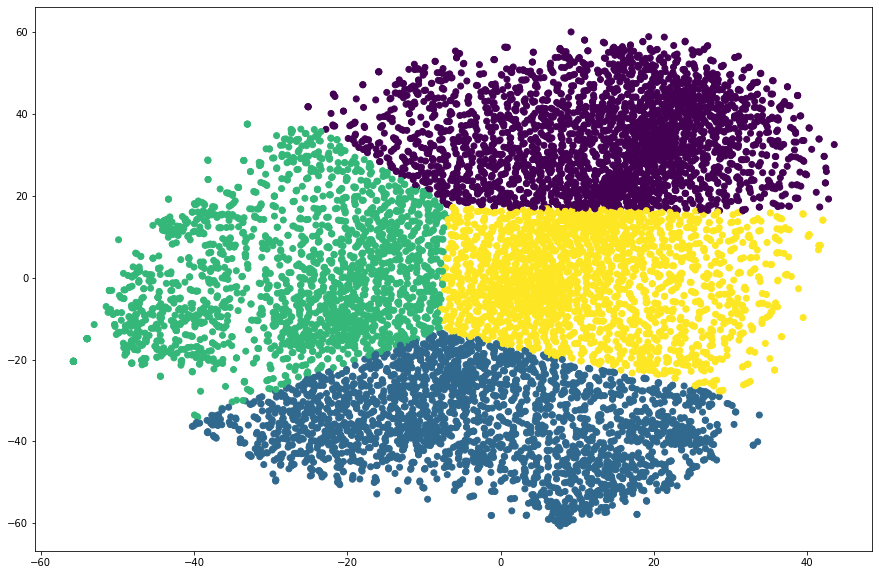

In [36]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=1e-04)
y_km = km.fit_predict(x)
plt.figure(figsize=(15,10))
plt.scatter(x[:,0], x[:,1], c=y_km)

In [38]:
unique, counts = np.unique(y_km, return_counts=True)

array([0, 1, 2, 3], dtype=int32)

In [107]:
labeled = data.copy()
labeled['LABEL'] = y_km
targets = np.unique(labeled['TARGET'])
labels = np.unique(labeled['LABEL'])
fractions = {}
for target in targets:
    total = np.count_nonzero(labeled['TARGET'] == target)
    fractions[target] = [None] * len(labels)
    for label in labels:
        is_target = labeled['TARGET'] == target
        is_label = labeled['LABEL'] == label
        match = labeled[is_target & is_label]
        fractions[target][label] = match.shape[0]/total

index = []
values = []
for key in fractions:
    index.append(key)
    values.append(fractions[key])
    print(key)
    for value in fractions[key]:
        print("\t" + str(value))

Bank account or service
	0.15060240963855423
	0.5572289156626506
	0.10542168674698796
	0.18674698795180722
Checking or savings account
	0.14402173913043478
	0.595108695652174
	0.07608695652173914
	0.18478260869565216
Consumer Loan
	0.27884615384615385
	0.3557692307692308
	0.09615384615384616
	0.2692307692307692
Credit card
	0.22950819672131148
	0.4098360655737705
	0.10109289617486339
	0.25956284153005466
Credit card or prepaid card
	0.16691505216095381
	0.488822652757079
	0.09388971684053651
	0.2503725782414307
Credit reporting
	0.4798061389337641
	0.06623586429725363
	0.2827140549273021
	0.17124394184168013
Credit reporting, credit repair services, or other personal consumer reports
	0.4209087803211479
	0.10146908097027674
	0.298599248377178
	0.17902289033139734
Debt collection
	0.3242152466367713
	0.08789237668161436
	0.36905829596412554
	0.21883408071748878
Money transfer, virtual currency, or money service
	0.18120805369127516
	0.5503355704697986
	0.10067114093959731
	0.16778523489